# In this notebook, I will attempt to understand how to do a GRU RNN using flax, and offer an example as to how to use it

At each time step, the GRU computes a “candidate activation vector” that combines information from the input and the previous hidden state. This candidate vector is then used to update the hidden state for the next time step.

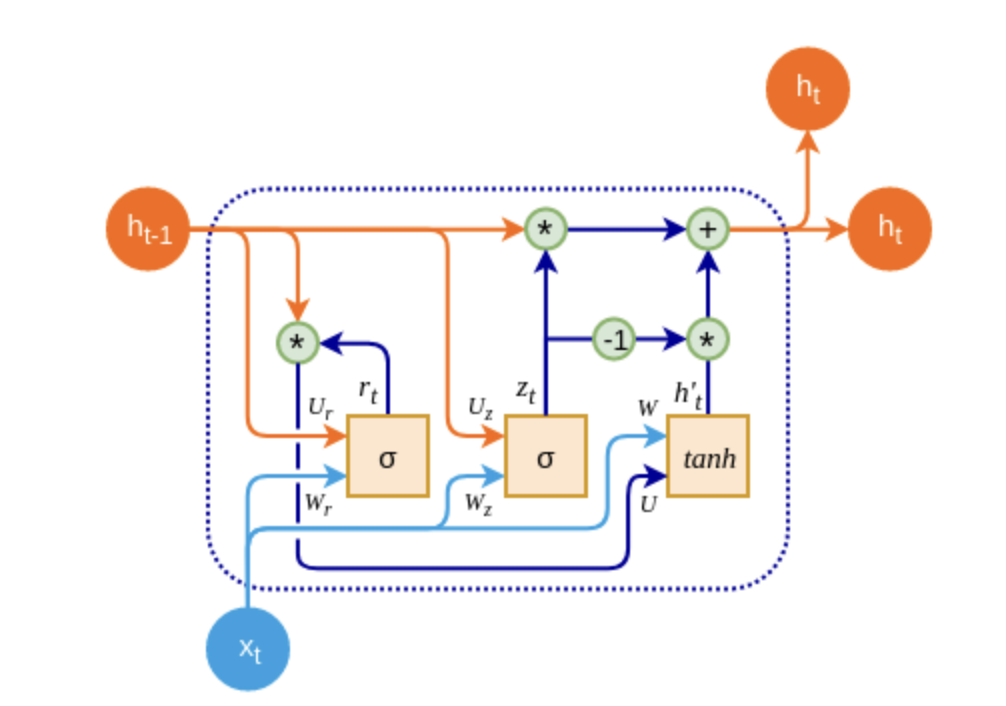

In [1]:
# ruff: noqa
import flax.linen as nn
import jax.numpy as jnp
class GRUCell(nn.Module):
    features: int

    @nn.compact
    def __call__(self, hidden_state, x_input):
        r"""
        The mathematical definition of the cell is as follows

        .. math::

            \begin{array}{ll}
            r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
            z = \sigma(W_{iz} x + b_{iz} + W_{hz} h) + b_{hz} \\
            h~ = \tanh(W_{ih~} x + b_{i~} + r * (W_{h~} h + b_{h~})) \\
            h_new = (1 - z) * h~ + z * h \\
            \end{array}
        """
        # Dense is just a linear layer w x + b ( and it does this for input and for the hidden state)
        # r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        r = nn.sigmoid(
            nn.Dense(features=self.features, name='reset_gate')(jnp.concatenate([x_input, hidden_state], axis=-1))
        )
        # z = \sigma(W_{iz} x + b_{iz} + W_{hz} h) + b_{hz} \\
        z = nn.sigmoid(
            nn.Dense(features=self.features, name='update_gate')(jnp.concatenate([x_input, hidden_state], axis=-1))
        )
        # n = \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) \\
        h_telda = nn.tanh(
            nn.Dense(features=self.features, name='candidate_gate')(jnp.concatenate([x_input, r * hidden_state], axis=-1))
        )
        # note that this h_new, just tells us how much we should update the hidden state according to the update gate to the new candidate
        h_new = (1 - z) * h_telda + z * hidden_state 
        return h_new, h_new

In [2]:
class GRU(nn.Module):
    hidden_size: int # number of features in the hidden state
    output_size: int # number of features in the output ( 2 in the case of gamma and beta)
    @nn.compact
    def __call__(self, measurement, hidden_state):
        """
        If your GRU has a hidden state increasing number of features in the hidden stateH means:

        - You're allowing the model to store more information across time steps

        - Each time step can represent more complex features, patterns, or dependencies

        - You're giving the GRU more representational capacity
        """
        gru_cell = GRUCell(features=self.hidden_size)


        if measurement.ndim == 1:
            measurement = measurement.reshape(1, -1)
        new_hidden_state, _ = gru_cell(hidden_state, measurement)
        # this returns the povm_params after linear regression through the hidden state which contains
        # the information of the previous time steps and this is optimized to output best povm_params
        output = nn.Dense(features = self.output_size)(new_hidden_state)
        return output, new_hidden_state


## initialize problem

In [3]:
from feedback_grape.utils.operators import create, destroy, cosm, sinm
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)
def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

## initialize model

In [4]:
import jax
from feedback_grape.fgrape import purity, calculate_trajectory
hidden_size = 32
initial_params = jnp.array([0.5, 0.5])
num_time_steps = 5
batch_size = 1
output_size = initial_params.shape[0]

rnn_model = GRU(hidden_size=hidden_size, output_size=output_size)
h_initial_state = jnp.zeros((batch_size, hidden_size))



rnn_params = rnn_model.init(jax.random.PRNGKey(0), initial_params, h_initial_state)

## Loss function

In [5]:
def loss_fn(rnn_params):
    """
    Loss function for purity optimization.
    Returns negative purity (we want to minimize this).
    """
    updated_rnn_params = rnn_params
    povm_params = initial_params
    rho_final, log_prob, _ = calculate_trajectory(
        rho_cav=rho_cav,
        povm_measure_operator=povm_measure_operator,
        initial_povm_params=povm_params,
        time_steps=num_time_steps,
        rnn_model=rnn_model,
        rnn_params=updated_rnn_params,
        rnn_state=h_initial_state,
    )
    purity_value = purity(rho=rho_final)
    loss1 = -purity_value
    loss2 = log_prob * jax.lax.stop_gradient(-purity_value)
    return loss1 + loss2



In [6]:
from feedback_grape.utils.optimizers import _optimize_L_BFGS
max_iter = 100
learning_rate = 0.01
convergence_threshold = 1e-10
best_model_params, iter_idx = _optimize_L_BFGS(
    loss_fn,
    rnn_params,
    max_iter,
    learning_rate,
    convergence_threshold,
)

ScopeParamShapeError: Initializer expected to generate shape (34, 32) but got shape (33, 32) instead for parameter "kernel" in "/GRUCell_0/reset_gate". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

## Pattern to convert stateful to stateless

In [ ]:
class StatefulClass:
    state: State

    def stateful_method(*args, **kwargs) -> Output:
        # Use self.state here
        pass

class StatelessClass:
    
    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
        # No state is used here
        pass